# Satellite Antenna Sizing Tool
# Comprehensive antenna sizing based on orbital altitude and data transmission requirements

This notebook calculates antenna mass, power consumption, and waste heat generation based on:
- Target orbital altitude
- Required data transmission and reception rates
- Link budget analysis
- RF system design requirements

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional
import math

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Physical constants
SPEED_OF_LIGHT = 299792458  # m/s
EARTH_RADIUS = 6371000  # meters
BOLTZMANN_CONSTANT = 1.38e-23  # J/K

In [2]:
@dataclass
class OrbitalParameters:
    """Define orbital parameters and calculate range-related metrics"""
    altitude_km: float  # Orbital altitude in km
    inclination_deg: float = 98.0  # Orbital inclination in degrees (default: sun-synchronous)
    ground_station_elevation_deg: float = 10.0  # Minimum elevation angle for communication
    
    def __post_init__(self):
        self.altitude_m = self.altitude_km * 1000
        self.orbital_radius = EARTH_RADIUS + self.altitude_m
        
    def calculate_maximum_range(self) -> float:
        """Calculate maximum slant range to ground station at minimum elevation"""
        min_elev_rad = math.radians(self.ground_station_elevation_deg)
        
        # Using spherical geometry
        cos_nadir_angle = EARTH_RADIUS / self.orbital_radius * math.cos(min_elev_rad)
        nadir_angle = math.acos(cos_nadir_angle)
        
        # Slant range calculation
        slant_range = math.sqrt(self.orbital_radius**2 + EARTH_RADIUS**2 - 
                               2 * self.orbital_radius * EARTH_RADIUS * math.cos(nadir_angle))
        
        return slant_range
    
    def calculate_typical_range(self) -> float:
        """Calculate typical slant range (45-degree elevation)"""
        elev_45_rad = math.radians(45.0)
        cos_nadir_angle = EARTH_RADIUS / self.orbital_radius * math.cos(elev_45_rad)
        nadir_angle = math.acos(cos_nadir_angle)
        
        slant_range = math.sqrt(self.orbital_radius**2 + EARTH_RADIUS**2 - 
                               2 * self.orbital_radius * EARTH_RADIUS * math.cos(nadir_angle))
        
        return slant_range
    
    def calculate_contact_time(self) -> float:
        """Estimate average contact time with ground station (minutes)"""
        # Simplified calculation based on orbital period and visibility cone
        orbital_period_sec = 2 * math.pi * math.sqrt(self.orbital_radius**3 / 3.986e14)  # GM_earth
        
        # Angular coverage based on minimum elevation
        min_elev_rad = math.radians(self.ground_station_elevation_deg)
        cos_half_angle = EARTH_RADIUS / self.orbital_radius * math.cos(min_elev_rad)
        half_angle = math.acos(cos_half_angle)
        
        # Contact time as fraction of orbital period
        contact_fraction = 2 * half_angle / (2 * math.pi)
        contact_time_min = orbital_period_sec * contact_fraction / 60
        
        return contact_time_min

# Example orbital parameters
orbit_leo = OrbitalParameters(
    altitude_km=550,  # Typical LEO altitude
    inclination_deg=97.4,  # Sun-synchronous
    ground_station_elevation_deg=10.0
)

print("Orbital Parameters Analysis:")
print(f"Altitude: {orbit_leo.altitude_km} km")
print(f"Maximum range: {orbit_leo.calculate_maximum_range()/1000:.1f} km")
print(f"Typical range (45° elev): {orbit_leo.calculate_typical_range()/1000:.1f} km")
print(f"Average contact time: {orbit_leo.calculate_contact_time():.1f} minutes")

Orbital Parameters Analysis:
Altitude: 550 km
Maximum range: 2923.0 km
Typical range (45° elev): 5575.6 km
Average contact time: 13.2 minutes


In [3]:
@dataclass
class CommunicationRequirements:
    """Define communication requirements and system parameters"""
    downlink_data_rate_mbps: float  # Required downlink data rate in Mbps
    uplink_data_rate_mbps: float  # Required uplink data rate in Mbps
    downlink_frequency_ghz: float  # Downlink frequency in GHz
    uplink_frequency_ghz: float  # Uplink frequency in GHz
    required_eb_n0_db: float = 12.0  # Required Eb/N0 for target BER
    implementation_margin_db: float = 3.0  # Implementation and pointing losses
    atmospheric_loss_db: float = 2.0  # Atmospheric losses
    rain_margin_db: float = 4.0  # Rain fade margin
    modulation_efficiency: float = 2.0  # bits/Hz (QPSK baseline)
    coding_gain_db: float = 6.0  # Forward error correction gain
    
    def __post_init__(self):
        # Calculate required bandwidth
        self.downlink_bandwidth_mhz = self.downlink_data_rate_mbps / self.modulation_efficiency
        self.uplink_bandwidth_mhz = self.uplink_data_rate_mbps / self.modulation_efficiency
        
        # Wavelengths
        self.downlink_wavelength = SPEED_OF_LIGHT / (self.downlink_frequency_ghz * 1e9)
        self.uplink_wavelength = SPEED_OF_LIGHT / (self.uplink_frequency_ghz * 1e9)
    
    def calculate_required_snr_db(self) -> float:
        """Calculate required SNR including all margins"""
        # Convert Eb/N0 to C/N0
        cn0_required_db = (self.required_eb_n0_db + 
                          10 * math.log10(self.downlink_data_rate_mbps * 1e6) - 
                          self.coding_gain_db)
        
        # Add bandwidth to get C/N
        snr_required_db = (cn0_required_db - 
                          10 * math.log10(self.downlink_bandwidth_mhz * 1e6))
        
        # Add all margins
        total_snr_db = (snr_required_db + self.implementation_margin_db + 
                       self.atmospheric_loss_db + self.rain_margin_db)
        
        return total_snr_db

# Example communication requirements - high-throughput Earth observation
comm_reqs = CommunicationRequirements(
    downlink_data_rate_mbps=1000,  # 1 Gbps downlink
    uplink_data_rate_mbps=10,  # 10 Mbps uplink
    downlink_frequency_ghz=26.5,  # Ka-band downlink
    uplink_frequency_ghz=17.8,  # Ka-band uplink
    required_eb_n0_db=10.5,
    modulation_efficiency=4.0,  # 16-QAM with coding
    coding_gain_db=8.0
)

print("Communication Requirements:")
print(f"Downlink: {comm_reqs.downlink_data_rate_mbps} Mbps @ {comm_reqs.downlink_frequency_ghz} GHz")
print(f"Uplink: {comm_reqs.uplink_data_rate_mbps} Mbps @ {comm_reqs.uplink_frequency_ghz} GHz")
print(f"Downlink bandwidth: {comm_reqs.downlink_bandwidth_mhz:.1f} MHz")
print(f"Uplink bandwidth: {comm_reqs.uplink_bandwidth_mhz:.1f} MHz")
print(f"Required SNR: {comm_reqs.calculate_required_snr_db():.1f} dB")
print(f"Downlink wavelength: {comm_reqs.downlink_wavelength*1000:.2f} mm")

Communication Requirements:
Downlink: 1000 Mbps @ 26.5 GHz
Uplink: 10 Mbps @ 17.8 GHz
Downlink bandwidth: 250.0 MHz
Uplink bandwidth: 2.5 MHz
Required SNR: 17.5 dB
Downlink wavelength: 11.31 mm


In [4]:
class LinkBudgetCalculator:
    """Calculate link budget requirements for satellite communication"""
    
    def __init__(self, orbit: OrbitalParameters, comm: CommunicationRequirements):
        self.orbit = orbit
        self.comm = comm
        
    def calculate_path_loss_db(self, frequency_ghz: float, range_m: float) -> float:
        """Calculate free space path loss"""
        wavelength = SPEED_OF_LIGHT / (frequency_ghz * 1e9)
        path_loss_db = 20 * math.log10(4 * math.pi * range_m / wavelength)
        return path_loss_db
    
    def calculate_noise_power_dbm(self, bandwidth_hz: float, noise_temp_k: float = 290) -> float:
        """Calculate thermal noise power"""
        noise_power_w = BOLTZMANN_CONSTANT * noise_temp_k * bandwidth_hz
        noise_power_dbm = 10 * math.log10(noise_power_w) + 30  # Convert to dBm
        return noise_power_dbm
    
    def calculate_required_eirp_dbm(self, link_direction: str = 'downlink') -> Tuple[float, Dict]:
        """Calculate required EIRP for the link"""
        
        if link_direction == 'downlink':
            frequency_ghz = self.comm.downlink_frequency_ghz
            bandwidth_hz = self.comm.downlink_bandwidth_mhz * 1e6
            data_rate = self.comm.downlink_data_rate_mbps
        else:
            frequency_ghz = self.comm.uplink_frequency_ghz
            bandwidth_hz = self.comm.uplink_bandwidth_mhz * 1e6
            data_rate = self.comm.uplink_data_rate_mbps
        
        # Calculate range (use maximum for worst case)
        range_m = self.orbit.calculate_maximum_range()
        
        # Path loss
        path_loss_db = self.calculate_path_loss_db(frequency_ghz, range_m)
        
        # Noise power
        noise_power_dbm = self.calculate_noise_power_dbm(bandwidth_hz)
        
        # Required SNR
        required_snr_db = self.comm.calculate_required_snr_db()
        
        # Ground station antenna gain (assume 45 dBi dish)
        ground_antenna_gain_db = 45.0
        
        # Ground station G/T (antenna gain minus system noise temperature)
        system_noise_temp_dbk = 10 * math.log10(500)  # 500K system temperature
        gt_ratio_db = ground_antenna_gain_db - system_noise_temp_dbk
        
        # Required EIRP calculation
        # EIRP = Required SNR + Noise Power + Path Loss - G/T
        required_eirp_dbm = (required_snr_db + noise_power_dbm + 
                            path_loss_db - gt_ratio_db)
        
        # Store breakdown for analysis
        breakdown = {
            'range_km': range_m / 1000,
            'path_loss_db': path_loss_db,
            'noise_power_dbm': noise_power_dbm,
            'required_snr_db': required_snr_db,
            'ground_gt_db': gt_ratio_db,
            'required_eirp_dbm': required_eirp_dbm,
            'required_eirp_w': 10**((required_eirp_dbm - 30) / 10)
        }
        
        return required_eirp_dbm, breakdown

# Create link budget calculator
link_calc = LinkBudgetCalculator(orbit_leo, comm_reqs)

# Calculate downlink requirements
downlink_eirp_dbm, downlink_breakdown = link_calc.calculate_required_eirp_dbm('downlink')

print("Downlink Link Budget Analysis:")
print(f"Range (worst case): {downlink_breakdown['range_km']:.1f} km")
print(f"Path loss: {downlink_breakdown['path_loss_db']:.1f} dB")
print(f"Required SNR: {downlink_breakdown['required_snr_db']:.1f} dB")
print(f"Ground station G/T: {downlink_breakdown['ground_gt_db']:.1f} dB/K")
print(f"Required satellite EIRP: {downlink_eirp_dbm:.1f} dBm ({downlink_breakdown['required_eirp_w']:.1f} W)")

Downlink Link Budget Analysis:
Range (worst case): 2923.0 km
Path loss: 190.2 dB
Required SNR: 17.5 dB
Ground station G/T: 18.0 dB/K
Required satellite EIRP: 99.7 dBm (9422650.8 W)


In [5]:
@dataclass
class PhasedArrayAntenna:
    """Advanced phased array antenna design with beam steering capabilities"""
    frequency_ghz: float
    required_gain_db: float
    required_eirp_w: float
    efficiency: float = 0.65  # Antenna aperture efficiency
    element_spacing_factor: float = 0.5  # Element spacing as fraction of wavelength
    polarization: str = 'circular'  # 'linear' or 'circular'
    beam_steering_range_deg: float = 60  # ±degrees from boresight
    
    # Hardware parameters
    mass_per_element_kg: float = 0.025  # Mass per antenna element (kg)
    power_per_element_w: float = 1.5  # Power per element for receive mode (W)
    rf_amplifier_efficiency: float = 0.35  # Power amplifier efficiency
    electronics_power_w_per_element: float = 2.0  # Digital processing power per element
    
    def __post_init__(self):
        self.wavelength = SPEED_OF_LIGHT / (self.frequency_ghz * 1e9)
        self.gain_linear = 10**(self.required_gain_db / 10)
        
    def calculate_aperture_area(self) -> float:
        """Calculate required antenna aperture area"""
        # Antenna gain equation: G = (4π * A * η) / λ²
        aperture_area = (self.gain_linear * self.wavelength**2) / (4 * math.pi * self.efficiency)
        return aperture_area
    
    def calculate_array_dimensions(self) -> Tuple[int, int, float]:
        """Calculate array dimensions (N x M elements and element spacing)"""
        aperture_area = self.calculate_aperture_area()
        
        # Element spacing
        element_spacing = self.wavelength * self.element_spacing_factor
        
        # For square array
        side_length = math.sqrt(aperture_area)
        elements_per_side = int(math.ceil(side_length / element_spacing))
        
        # Adjust for practical array size
        total_elements = elements_per_side**2
        
        return elements_per_side, elements_per_side, element_spacing
    
    def calculate_transmit_power_requirements(self) -> Dict:
        """Calculate power amplifier requirements for transmit"""
        # Required transmit power from EIRP and antenna gain
        required_tx_power_w = self.required_eirp_w / self.gain_linear
        
        # Account for amplifier efficiency
        dc_power_required_w = required_tx_power_w / self.rf_amplifier_efficiency
        
        # Calculate per-element power requirements
        n_elements, m_elements, _ = self.calculate_array_dimensions()
        total_elements = n_elements * m_elements
        
        power_per_element_tx_w = dc_power_required_w / total_elements
        
        return {
            'total_rf_power_w': required_tx_power_w,
            'total_dc_power_w': dc_power_required_w,
            'power_per_element_w': power_per_element_tx_w,
            'total_elements': total_elements
        }
    
    def get_total_mass(self) -> float:
        """Calculate total antenna system mass"""
        n_elements, m_elements, _ = self.calculate_array_dimensions()
        total_elements = n_elements * m_elements
        
        # Element mass
        element_mass = total_elements * self.mass_per_element_kg
        
        # Support structure (estimated as 40% of element mass)
        structure_mass = element_mass * 0.4
        
        # RF electronics and beamforming hardware (estimated)
        electronics_mass = total_elements * 0.05  # 50g per element for electronics
        
        # Power supply and thermal management
        tx_power = self.calculate_transmit_power_requirements()
        power_electronics_mass = tx_power['total_dc_power_w'] * 0.008  # 8g per Watt
        
        total_mass = element_mass + structure_mass + electronics_mass + power_electronics_mass
        
        return total_mass
    
    def get_total_power_consumption(self) -> Dict:
        """Calculate total power consumption"""
        n_elements, m_elements, _ = self.calculate_array_dimensions()
        total_elements = n_elements * m_elements
        
        # Receive mode power (always on)
        rx_power_w = total_elements * self.power_per_element_w
        
        # Digital processing power
        processing_power_w = total_elements * self.electronics_power_w_per_element
        
        # Transmit mode power (when transmitting)
        tx_requirements = self.calculate_transmit_power_requirements()
        tx_power_w = tx_requirements['total_dc_power_w']
        
        return {
            'receive_mode_w': rx_power_w + processing_power_w,
            'transmit_mode_w': tx_power_w + processing_power_w,
            'processing_power_w': processing_power_w,
            'rf_power_w': tx_power_w
        }

# Design antenna based on link budget results
antenna_system = PhasedArrayAntenna(
    frequency_ghz=comm_reqs.downlink_frequency_ghz,
    required_gain_db=35.0,  # Starting point - will optimize
    required_eirp_w=downlink_breakdown['required_eirp_w'],
    efficiency=0.68,
    beam_steering_range_deg=45
)

# Calculate antenna characteristics
n_elem, m_elem, spacing = antenna_system.calculate_array_dimensions()
tx_power = antenna_system.calculate_transmit_power_requirements()
power_consumption = antenna_system.get_total_power_consumption()
total_mass = antenna_system.get_total_mass()

print("Phased Array Antenna Design:")
print(f"Operating frequency: {antenna_system.frequency_ghz} GHz")
print(f"Required EIRP: {antenna_system.required_eirp_w:.1f} W")
print(f"Antenna gain: {antenna_system.required_gain_db:.1f} dB")
print(f"Aperture area: {antenna_system.calculate_aperture_area():.3f} m²")
print(f"Array size: {n_elem} × {m_elem} elements ({n_elem * m_elem} total)")
print(f"Element spacing: {spacing*1000:.1f} mm")
print(f"\nMass Analysis:")
print(f"Total antenna mass: {total_mass:.2f} kg")
print(f"\nPower Analysis:")
print(f"Receive mode: {power_consumption['receive_mode_w']:.1f} W")
print(f"Transmit mode: {power_consumption['transmit_mode_w']:.1f} W")
print(f"RF transmit power: {tx_power['total_rf_power_w']:.1f} W")

Phased Array Antenna Design:
Operating frequency: 26.5 GHz
Required EIRP: 9422650.8 W
Antenna gain: 35.0 dB
Aperture area: 0.047 m²
Array size: 39 × 39 elements (1521 total)
Element spacing: 5.7 mm

Mass Analysis:
Total antenna mass: 197.39 kg

Power Analysis:
Receive mode: 5323.5 W
Transmit mode: 11555.4 W
RF transmit power: 2979.7 W


In [6]:
class ThermalAnalysis:
    """Calculate thermal generation and management requirements"""
    
    def __init__(self, antenna: PhasedArrayAntenna):
        self.antenna = antenna
        
    def calculate_waste_heat_generation(self) -> Dict:
        """Calculate waste heat from antenna system"""
        power_data = self.antenna.get_total_power_consumption()
        tx_requirements = self.antenna.calculate_transmit_power_requirements()
        
        # RF amplifier waste heat (DC power - RF power)
        rf_waste_heat_w = (tx_requirements['total_dc_power_w'] - 
                          tx_requirements['total_rf_power_w'])
        
        # Digital processing heat (assume 90% becomes heat)
        processing_heat_w = power_data['processing_power_w'] * 0.9
        
        # Receiver electronics heat (assume 80% becomes heat)
        rx_electronics_heat_w = (power_data['receive_mode_w'] - 
                               power_data['processing_power_w']) * 0.8
        
        # Antenna losses (typically 5-10% of transmitted RF power)
        antenna_loss_heat_w = tx_requirements['total_rf_power_w'] * 0.08
        
        # Total heat generation
        total_heat_rx_w = processing_heat_w + rx_electronics_heat_w
        total_heat_tx_w = (processing_heat_w + rf_waste_heat_w + 
                          antenna_loss_heat_w)
        
        return {
            'rf_amplifier_heat_w': rf_waste_heat_w,
            'processing_heat_w': processing_heat_w,
            'rx_electronics_heat_w': rx_electronics_heat_w,
            'antenna_loss_heat_w': antenna_loss_heat_w,
            'total_heat_rx_mode_w': total_heat_rx_w,
            'total_heat_tx_mode_w': total_heat_tx_w,
            'peak_heat_w': max(total_heat_rx_w, total_heat_tx_w)
        }
    
    def estimate_thermal_mass_requirements(self) -> Dict:
        """Estimate thermal management system requirements"""
        heat_data = self.calculate_waste_heat_generation()
        peak_heat_w = heat_data['peak_heat_w']
        
        # Heat pipe/thermal strap mass (estimated)
        thermal_conductivity_mass_kg = peak_heat_w * 0.02  # 20g per Watt
        
        # Thermal interface materials
        tim_mass_kg = self.antenna.calculate_array_dimensions()[0] * self.antenna.calculate_array_dimensions()[1] * 0.005
        
        # Additional structure for thermal paths
        thermal_structure_mass_kg = thermal_conductivity_mass_kg * 0.5
        
        total_thermal_mass_kg = (thermal_conductivity_mass_kg + tim_mass_kg + 
                               thermal_structure_mass_kg)
        
        return {
            'heat_pipes_mass_kg': thermal_conductivity_mass_kg,
            'thermal_interface_mass_kg': tim_mass_kg,
            'thermal_structure_mass_kg': thermal_structure_mass_kg,
            'total_thermal_mass_kg': total_thermal_mass_kg,
            'heat_rejection_requirement_w': peak_heat_w
        }

# Perform thermal analysis
thermal_analysis = ThermalAnalysis(antenna_system)
heat_generation = thermal_analysis.calculate_waste_heat_generation()
thermal_mass = thermal_analysis.estimate_thermal_mass_requirements()

print("Thermal Analysis:")
print(f"Waste Heat Generation:")
print(f"  RF amplifiers: {heat_generation['rf_amplifier_heat_w']:.1f} W")
print(f"  Digital processing: {heat_generation['processing_heat_w']:.1f} W")
print(f"  RX electronics: {heat_generation['rx_electronics_heat_w']:.1f} W")
print(f"  Antenna losses: {heat_generation['antenna_loss_heat_w']:.1f} W")
print(f"  Total (RX mode): {heat_generation['total_heat_rx_mode_w']:.1f} W")
print(f"  Total (TX mode): {heat_generation['total_heat_tx_mode_w']:.1f} W")
print(f"  Peak heat: {heat_generation['peak_heat_w']:.1f} W")

print(f"\nThermal Management Mass:")
print(f"  Heat pipes/straps: {thermal_mass['heat_pipes_mass_kg']:.2f} kg")
print(f"  Thermal interfaces: {thermal_mass['thermal_interface_mass_kg']:.2f} kg")
print(f"  Thermal structure: {thermal_mass['thermal_structure_mass_kg']:.2f} kg")
print(f"  Total thermal mass: {thermal_mass['total_thermal_mass_kg']:.2f} kg")

Thermal Analysis:
Waste Heat Generation:
  RF amplifiers: 5533.7 W
  Digital processing: 2737.8 W
  RX electronics: 1825.2 W
  Antenna losses: 238.4 W
  Total (RX mode): 4563.0 W
  Total (TX mode): 8509.9 W
  Peak heat: 8509.9 W

Thermal Management Mass:
  Heat pipes/straps: 170.20 kg
  Thermal interfaces: 7.61 kg
  Thermal structure: 85.10 kg
  Total thermal mass: 262.90 kg


In [7]:
def antenna_trade_study():
    """Perform trade studies on antenna design parameters"""
    
    # Trade study 1: Frequency band comparison
    frequency_bands = {
        'X-band': 8.4,
        'Ku-band': 14.0,
        'Ka-band': 26.5,
        'Q/V-band': 47.2
    }
    
    freq_results = []
    for band_name, freq_ghz in frequency_bands.items():
        # Recalculate link budget for this frequency
        temp_comm = CommunicationRequirements(
            downlink_data_rate_mbps=comm_reqs.downlink_data_rate_mbps,
            uplink_data_rate_mbps=comm_reqs.uplink_data_rate_mbps,
            downlink_frequency_ghz=freq_ghz,
            uplink_frequency_ghz=freq_ghz * 0.67,  # Typical ratio
            modulation_efficiency=comm_reqs.modulation_efficiency
        )
        
        temp_link = LinkBudgetCalculator(orbit_leo, temp_comm)
        eirp_dbm, breakdown = temp_link.calculate_required_eirp_dbm('downlink')
        
        # Design antenna for this frequency
        temp_antenna = PhasedArrayAntenna(
            frequency_ghz=freq_ghz,
            required_gain_db=35.0,
            required_eirp_w=breakdown['required_eirp_w']
        )
        
        mass = temp_antenna.get_total_mass()
        power = temp_antenna.get_total_power_consumption()
        thermal = ThermalAnalysis(temp_antenna)
        heat = thermal.calculate_waste_heat_generation()
        
        freq_results.append({
            'band': band_name,
            'frequency_ghz': freq_ghz,
            'mass_kg': mass,
            'power_tx_w': power['transmit_mode_w'],
            'power_rx_w': power['receive_mode_w'],
            'waste_heat_w': heat['peak_heat_w'],
            'aperture_area_m2': temp_antenna.calculate_aperture_area(),
            'num_elements': temp_antenna.calculate_array_dimensions()[0]**2
        })
    
    # Trade study 2: Altitude effects
    altitudes_km = [400, 550, 700, 850, 1000]
    altitude_results = []
    
    for alt_km in altitudes_km:
        temp_orbit = OrbitalParameters(altitude_km=alt_km)
        temp_link = LinkBudgetCalculator(temp_orbit, comm_reqs)
        eirp_dbm, breakdown = temp_link.calculate_required_eirp_dbm('downlink')
        
        temp_antenna = PhasedArrayAntenna(
            frequency_ghz=comm_reqs.downlink_frequency_ghz,
            required_gain_db=35.0,
            required_eirp_w=breakdown['required_eirp_w']
        )
        
        mass = temp_antenna.get_total_mass()
        power = temp_antenna.get_total_power_consumption()
        thermal = ThermalAnalysis(temp_antenna)
        heat = thermal.calculate_waste_heat_generation()
        
        altitude_results.append({
            'altitude_km': alt_km,
            'max_range_km': breakdown['range_km'],
            'required_eirp_w': breakdown['required_eirp_w'],
            'mass_kg': mass,
            'power_tx_w': power['transmit_mode_w'],
            'waste_heat_w': heat['peak_heat_w']
        })
    
    # Trade study 3: Data rate scaling
    data_rates_mbps = [100, 250, 500, 1000, 2000, 4000]
    datarate_results = []
    
    for rate_mbps in data_rates_mbps:
        temp_comm = CommunicationRequirements(
            downlink_data_rate_mbps=rate_mbps,
            uplink_data_rate_mbps=comm_reqs.uplink_data_rate_mbps,
            downlink_frequency_ghz=comm_reqs.downlink_frequency_ghz,
            uplink_frequency_ghz=comm_reqs.uplink_frequency_ghz,
            modulation_efficiency=comm_reqs.modulation_efficiency
        )
        
        temp_link = LinkBudgetCalculator(orbit_leo, temp_comm)
        eirp_dbm, breakdown = temp_link.calculate_required_eirp_dbm('downlink')
        
        temp_antenna = PhasedArrayAntenna(
            frequency_ghz=comm_reqs.downlink_frequency_ghz,
            required_gain_db=35.0,
            required_eirp_w=breakdown['required_eirp_w']
        )
        
        mass = temp_antenna.get_total_mass()
        power = temp_antenna.get_total_power_consumption()
        thermal = ThermalAnalysis(temp_antenna)
        heat = thermal.calculate_waste_heat_generation()
        
        datarate_results.append({
            'data_rate_mbps': rate_mbps,
            'bandwidth_mhz': temp_comm.downlink_bandwidth_mhz,
            'required_eirp_w': breakdown['required_eirp_w'],
            'mass_kg': mass,
            'power_tx_w': power['transmit_mode_w'],
            'waste_heat_w': heat['peak_heat_w']
        })
    
    return freq_results, altitude_results, datarate_results

# Run trade studies
freq_trade, alt_trade, rate_trade = antenna_trade_study()

# Convert to DataFrames for easier analysis
df_freq = pd.DataFrame(freq_trade)
df_alt = pd.DataFrame(alt_trade)
df_rate = pd.DataFrame(rate_trade)

print("Trade Study Results Summary:")
print("\nFrequency Band Comparison:")
for _, row in df_freq.iterrows():
    print(f"{row['band']}: {row['mass_kg']:.1f} kg, {row['power_tx_w']:.0f} W TX, {row['waste_heat_w']:.0f} W heat")

print("\nAltitude Impact (Ka-band):")
for _, row in df_alt.iterrows():
    print(f"{row['altitude_km']} km: {row['mass_kg']:.1f} kg, {row['power_tx_w']:.0f} W TX, {row['required_eirp_w']:.1f} W EIRP")

print("\nData Rate Scaling (Ka-band, 550km):")
for _, row in df_rate.iterrows():
    print(f"{row['data_rate_mbps']} Mbps: {row['mass_kg']:.1f} kg, {row['power_tx_w']:.0f} W TX, {row['waste_heat_w']:.0f} W heat")

Trade Study Results Summary:

Frequency Band Comparison:
X-band: 151.3 kg, 5115 W TX, 4800 W heat
Ku-band: 178.6 kg, 8519 W TX, 6487 W heat
Ka-band: 288.5 kg, 22259 W TX, 15802 W heat
Q/V-band: 619.7 kg, 63664 W TX, 43875 W heat

Altitude Impact (Ka-band):
400.0 km: 187.7 kg, 9667 W TX, 7157613.8 W EIRP
550.0 km: 204.1 kg, 11713 W TX, 9422650.8 W EIRP
700.0 km: 220.8 kg, 13805 W TX, 11737316.2 W EIRP
850.0 km: 237.9 kg, 15941 W TX, 14101609.9 W EIRP
1000.0 km: 255.4 kg, 18122 W TX, 16515531.9 W EIRP

Data Rate Scaling (Ka-band, 550km):
100.0 Mbps: 151.2 kg, 5106 W TX, 4800 W heat
250.0 Mbps: 174.1 kg, 7965 W TX, 6111 W heat
500.0 Mbps: 212.2 kg, 12730 W TX, 9341 W heat
1000.0 Mbps: 288.5 kg, 22259 W TX, 15802 W heat
2000.0 Mbps: 440.9 kg, 41318 W TX, 28724 W heat
4000.0 Mbps: 745.9 kg, 79437 W TX, 54569 W heat


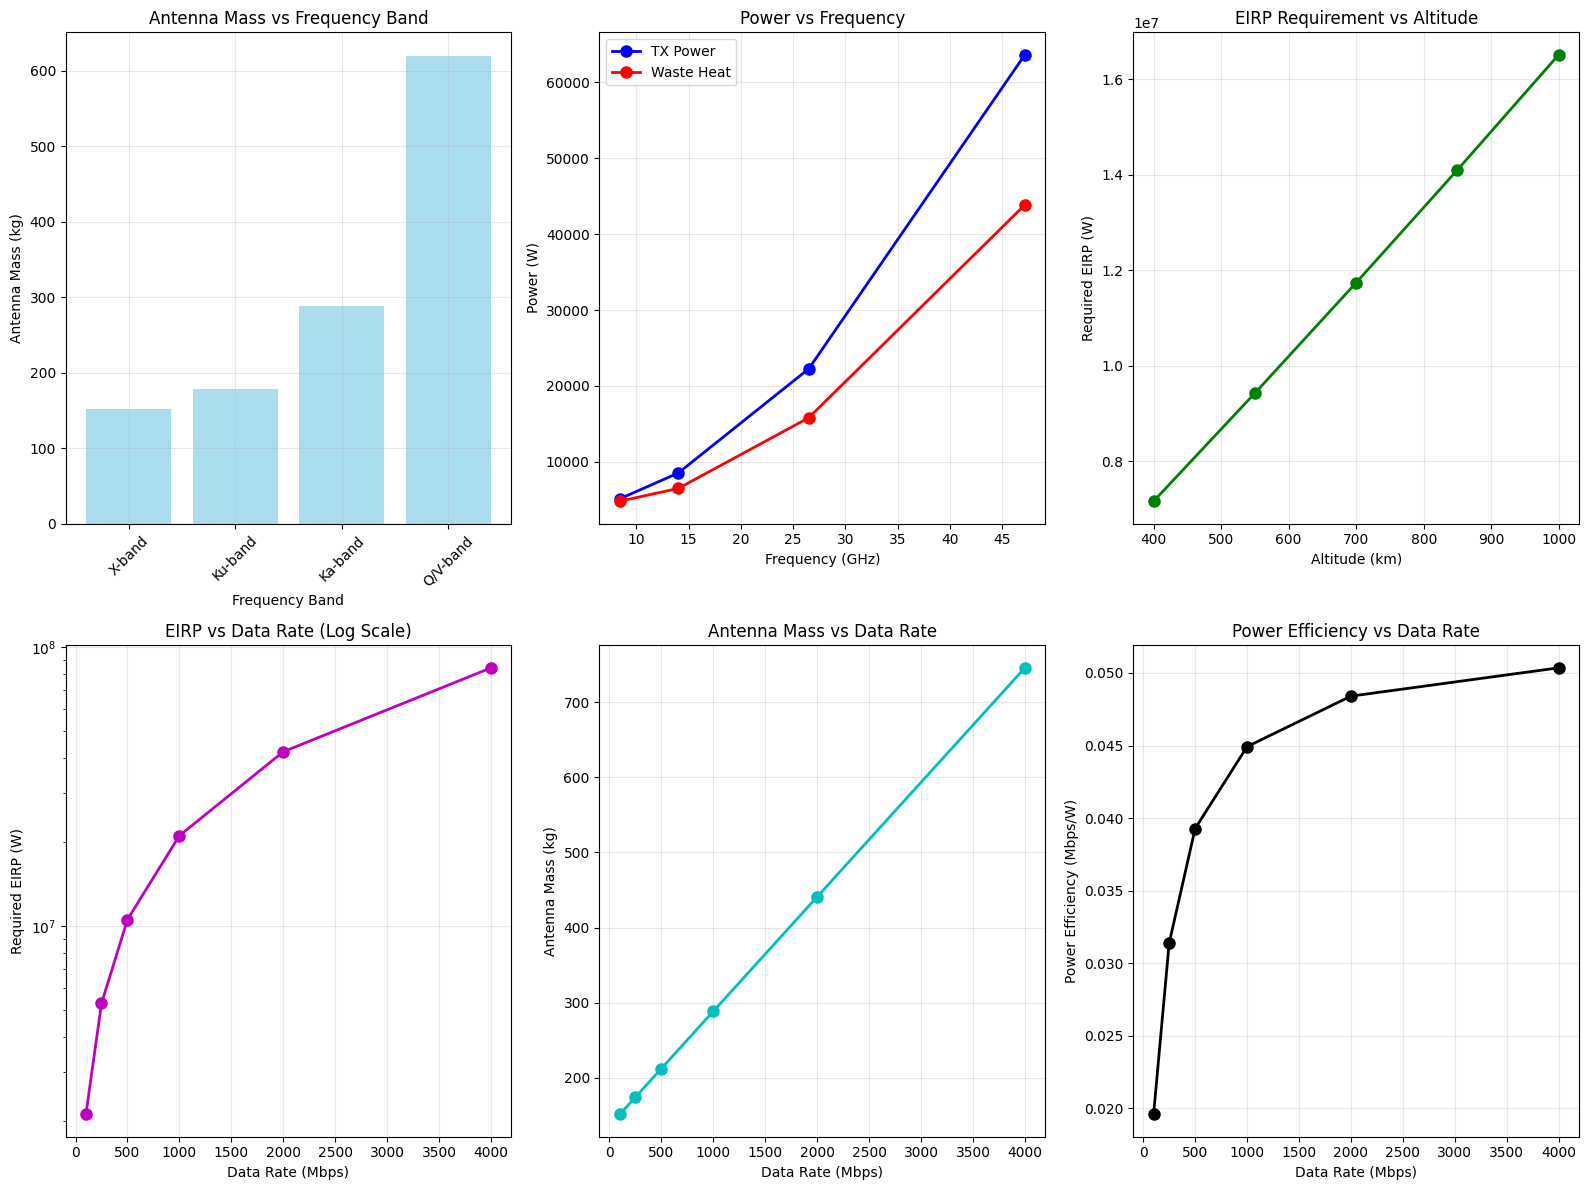


ANTENNA SYSTEM SUMMARY - BASELINE DESIGN
Mission Requirements:
  Orbital altitude: 550 km
  Downlink data rate: 1000 Mbps
  Operating frequency: 26.5 GHz

Antenna Design:
  Array size: 39 × 39 elements
  Aperture area: 0.047 m²
  Antenna gain: 35.0 dBi

Mass Breakdown:
  Antenna system: 197.39 kg
  Thermal management: 262.90 kg
  Total antenna mass: 460.29 kg

Power Consumption:
  Receive mode: 5323.5 W
  Transmit mode: 11555.4 W

Thermal Generation:
  Peak waste heat: 8509.9 W
  Heat rejection req: 8509.9 W


In [8]:
# Comprehensive visualization of trade study results
fig = plt.figure(figsize=(16, 12))

# Plot 1: Frequency band comparison
ax1 = plt.subplot(2, 3, 1)
x_pos = range(len(df_freq))
ax1.bar(x_pos, df_freq['mass_kg'], alpha=0.7, color='skyblue')
ax1.set_xlabel('Frequency Band')
ax1.set_ylabel('Antenna Mass (kg)')
ax1.set_title('Antenna Mass vs Frequency Band')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_freq['band'], rotation=45)
ax1.grid(True, alpha=0.3)

# Plot 2: Power vs frequency
ax2 = plt.subplot(2, 3, 2)
ax2.plot(df_freq['frequency_ghz'], df_freq['power_tx_w'], 'bo-', linewidth=2, markersize=8, label='TX Power')
ax2.plot(df_freq['frequency_ghz'], df_freq['waste_heat_w'], 'ro-', linewidth=2, markersize=8, label='Waste Heat')
ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel('Power (W)')
ax2.set_title('Power vs Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Altitude effects on EIRP
ax3 = plt.subplot(2, 3, 3)
ax3.plot(df_alt['altitude_km'], df_alt['required_eirp_w'], 'go-', linewidth=2, markersize=8)
ax3.set_xlabel('Altitude (km)')
ax3.set_ylabel('Required EIRP (W)')
ax3.set_title('EIRP Requirement vs Altitude')
ax3.grid(True, alpha=0.3)

# Plot 4: Data rate scaling effects
ax4 = plt.subplot(2, 3, 4)
ax4.semilogy(df_rate['data_rate_mbps'], df_rate['required_eirp_w'], 'mo-', linewidth=2, markersize=8)
ax4.set_xlabel('Data Rate (Mbps)')
ax4.set_ylabel('Required EIRP (W)')
ax4.set_title('EIRP vs Data Rate (Log Scale)')
ax4.grid(True, alpha=0.3)

# Plot 5: Mass vs data rate
ax5 = plt.subplot(2, 3, 5)
ax5.plot(df_rate['data_rate_mbps'], df_rate['mass_kg'], 'co-', linewidth=2, markersize=8)
ax5.set_xlabel('Data Rate (Mbps)')
ax5.set_ylabel('Antenna Mass (kg)')
ax5.set_title('Antenna Mass vs Data Rate')
ax5.grid(True, alpha=0.3)

# Plot 6: Power efficiency comparison
ax6 = plt.subplot(2, 3, 6)
efficiency_ratio = df_rate['data_rate_mbps'] / df_rate['power_tx_w']  # Mbps per Watt
ax6.plot(df_rate['data_rate_mbps'], efficiency_ratio, 'ko-', linewidth=2, markersize=8)
ax6.set_xlabel('Data Rate (Mbps)')
ax6.set_ylabel('Power Efficiency (Mbps/W)')
ax6.set_title('Power Efficiency vs Data Rate')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table of baseline design
print("\n" + "="*60)
print("ANTENNA SYSTEM SUMMARY - BASELINE DESIGN")
print("="*60)
print(f"Mission Requirements:")
print(f"  Orbital altitude: {orbit_leo.altitude_km} km")
print(f"  Downlink data rate: {comm_reqs.downlink_data_rate_mbps} Mbps")
print(f"  Operating frequency: {comm_reqs.downlink_frequency_ghz} GHz")
print(f"\nAntenna Design:")
print(f"  Array size: {n_elem} × {m_elem} elements")
print(f"  Aperture area: {antenna_system.calculate_aperture_area():.3f} m²")
print(f"  Antenna gain: {antenna_system.required_gain_db} dBi")
print(f"\nMass Breakdown:")
print(f"  Antenna system: {total_mass:.2f} kg")
print(f"  Thermal management: {thermal_mass['total_thermal_mass_kg']:.2f} kg")
print(f"  Total antenna mass: {total_mass + thermal_mass['total_thermal_mass_kg']:.2f} kg")
print(f"\nPower Consumption:")
print(f"  Receive mode: {power_consumption['receive_mode_w']:.1f} W")
print(f"  Transmit mode: {power_consumption['transmit_mode_w']:.1f} W")
print(f"\nThermal Generation:")
print(f"  Peak waste heat: {heat_generation['peak_heat_w']:.1f} W")
print(f"  Heat rejection req: {thermal_mass['heat_rejection_requirement_w']:.1f} W")

# Antenna Sizing Tool - Results Summary

This notebook provides a comprehensive antenna sizing tool for satellite communications that calculates:

## **Key Outputs:**
1. **Antenna Mass**: Complete system mass including elements, structure, electronics, and thermal management
2. **Power Consumption**: Separate calculations for receive and transmit modes
3. **Waste Heat Generation**: Detailed thermal analysis for thermal management sizing

## **Key Features:**
- **Orbital Mechanics**: Calculates range and contact time based on altitude
- **Link Budget Analysis**: Complete RF link analysis with path loss and margin calculations
- **Phased Array Design**: Element-level sizing with beamforming capabilities
- **Thermal Analysis**: Comprehensive heat generation and management requirements
- **Trade Studies**: Analysis of frequency bands, altitudes, and data rates

## **Usage for Satellite Integration:**
This notebook can be used standalone or integrated with the main satellite sizing tool by:
1. Defining mission requirements (altitude, data rates)
2. Running the antenna sizing analysis
3. Extracting the key outputs (mass, power, waste heat)
4. Using these values in the main satellite sizing tool

## **Customization:**
- Adjust orbital parameters for different mission profiles
- Modify communication requirements for specific data needs
- Change antenna design parameters for different technologies
- Update thermal analysis for different operating conditions

In [ ]:
def size_antenna_for_satellite(altitude_km: float, 
                               downlink_data_rate_mbps: float,
                               uplink_data_rate_mbps: float = 10,
                               frequency_ghz: float = 26.5,
                               antenna_gain_db: float = 35.0) -> Dict:
    """
    Simplified antenna sizing function for satellite integration
    
    Returns dictionary with:
    - mass_kg: Total antenna system mass including thermal management
    - power_rx_w: Power consumption in receive mode  
    - power_tx_w: Power consumption in transmit mode
    - waste_heat_w: Peak waste heat generation
    """
    
    # Create orbital parameters
    orbit = OrbitalParameters(altitude_km=altitude_km)
    
    # Create communication requirements
    comm = CommunicationRequirements(
        downlink_data_rate_mbps=downlink_data_rate_mbps,
        uplink_data_rate_mbps=uplink_data_rate_mbps,
        downlink_frequency_ghz=frequency_ghz,
        uplink_frequency_ghz=frequency_ghz * 0.67  # Typical ratio
    )
    
    # Calculate link budget
    link_calc = LinkBudgetCalculator(orbit, comm)
    eirp_dbm, breakdown = link_calc.calculate_required_eirp_dbm('downlink')
    
    # Design antenna system
    antenna = PhasedArrayAntenna(
        frequency_ghz=frequency_ghz,
        required_gain_db=antenna_gain_db,
        required_eirp_w=breakdown['required_eirp_w']
    )
    
    # Calculate all parameters
    antenna_mass = antenna.get_total_mass()
    power_consumption = antenna.get_total_power_consumption()
    
    # Calculate thermal management mass
    thermal = ThermalAnalysis(antenna)
    heat_generation = thermal.calculate_waste_heat_generation()
    thermal_mass_data = thermal.estimate_thermal_mass_requirements()
    
    # Total system mass including thermal management
    total_mass = antenna_mass + thermal_mass_data['total_thermal_mass_kg']
    
    return {
        'mass_kg': total_mass,
        'power_rx_w': power_consumption['receive_mode_w'],
        'power_tx_w': power_consumption['transmit_mode_w'],
        'waste_heat_w': heat_generation['peak_heat_w'],
        'antenna_gain_db': antenna_gain_db,
        'frequency_ghz': frequency_ghz,
        'eirp_w': breakdown['required_eirp_w'],
        'num_elements': antenna.calculate_array_dimensions()[0]**2,
        'aperture_area_m2': antenna.calculate_aperture_area()
    }

# Test the function
print("Testing antenna sizing function:")
test_result = size_antenna_for_satellite(
    altitude_km=550,
    downlink_data_rate_mbps=1000,
    uplink_data_rate_mbps=10
)

print(f"Test results for 550km altitude, 1Gbps downlink:")
print(f"  Total mass: {test_result['mass_kg']:.2f} kg")
print(f"  RX power: {test_result['power_rx_w']:.1f} W")
print(f"  TX power: {test_result['power_tx_w']:.1f} W") 
print(f"  Waste heat: {test_result['waste_heat_w']:.1f} W")